# Feature Extraction (Keypoint Features)

**Author**: Maleakhi Agung Wijaya  
**Email**: maw219@cam.ac.uk  
**Description**: This file contains code for extracting keypoint features. Particularly, we consider SIFT, BRIEF, and ORB. Subsequently, we further pre-process these keypoints and feature descriptors using bag of visual words and compare their discriminative capabilities by training various ML models.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.graph_objects as go
import scipy.io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist

# Images
import os
import cv2
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.style as style
from skimage.io import imread, imshow
import re

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, backend as K, callbacks

In [3]:
%run Utilities.ipynb

## Load and Preprocess Dataset

This section load shell images one-by-one. We primarily explore and preprocess the dataset in this section

In [4]:
filenames = sorted(os.listdir(SHELL_IMAGES_DATA))
X_species, y_species = preprocess_x_y(filenames)

# Test outputs
print(X_species[0])
print(y_species[0])

('Aandara_consociata_10_A.jpg', 'Aandara_consociata_10_B.jpg')
Aandara_consociata


Aandara_consociata


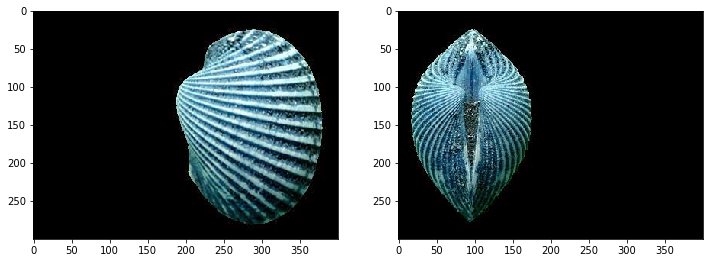

In [32]:
# Test visualise image
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print(y_species[0])
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][0]))
image2 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][1]))
ax1.imshow(image1)
ax2.imshow(image2)

plt.show()

## SIFT

This section conduct feature extraction using SIFT.

### Feature Extraction  

In [34]:
X_sift = []
y_sift = y_species
sift = cv2.xfeatures2d.SIFT_create()

# Get feature descriptors from all images
for X in tqdm(X_species):
    X_a = X[0] # A position
    X_b = X[1]
    
    # Open the image in gray scale
    image_a = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_a),
                   cv2.IMREAD_GRAYSCALE)
    image_b = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_b),
                   cv2.IMREAD_GRAYSCALE)
    
    kp_a, descriptors_a = sift.detectAndCompute(image_a, None)
    kp_b, descriptors_b = sift.detectAndCompute(image_b, None)
    
    X_sift.append((descriptors_a, descriptors_b))

In [35]:
# Concatenate rear and front view keypoints
X_sift_concatenate = [] # concatenated version of X_sift, considering front and rear views at once
for x in X_sift:
    X_sift_concatenate.append(np.concatenate((x[0], x[1])))

### Visualisation  

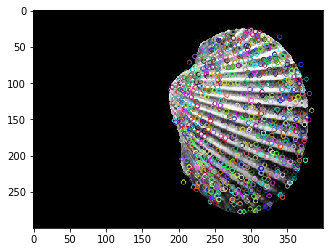

In [36]:
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][0]),
                   cv2.IMREAD_GRAYSCALE)
sift = cv2.xfeatures2d.SIFT_create()
kp, descriptors = sift.detectAndCompute(image1, None) # can add mask
img = cv2.drawKeypoints(image1, kp, None)
plt.imshow(img)
plt.show()

### Bag of Visual Words

In [37]:
## Build dictionary of visual words
# Concatenate all keypoints
X_sift_full = np.vstack(X_sift_concatenate)

# Build vocabulary of differing sizes
# vocabulary_sizes = [100, 500, 1000] # we already have 200
# for size in vocabulary_sizes:
#     kmeans = KMeans(n_clusters=size)
#     kmeans.fit(X_sift_full)
#     filename = f"../results/vocab_{size}.pickle"
#     save_object(kmeans, filename)

In [44]:
## Load dictionary
kmeans_100 = load_object("../results/vocab_100.pickle")
vocab_100 = kmeans_100.cluster_centers_

kmeans_200 = load_object("../results/vocab_200.pickle")
vocab_200 = kmeans_200.cluster_centers_

kmeans_500 = load_object("../results/vocab_500.pickle")
vocab_500 = kmeans_500.cluster_centers_

kmeans_1000 = load_object("../results/vocab_1000.pickle")
vocab_1000 = kmeans_1000.cluster_centers_

In [45]:
# Build histograms
X_100 = build_histograms(vocab_100, 100, X_species)
X_200 = build_histograms(vocab_200, 200, X_species)
X_500 = build_histograms(vocab_500, 500, X_species)
X_1000 = build_histograms(vocab_1000, 1000, X_species)

# Whiten results
scaler = StandardScaler()
X_100_scaled = scaler.fit_transform(X_100)
X_200_scaled = scaler.fit_transform(X_200)
X_500_scaled = scaler.fit_transform(X_500)
X_1000_scaled = scaler.fit_transform(X_1000)

### Classification

#### Standard ML Models

The following consider SVC and random forest.

In [46]:
## Hyperparameter configurations and result storage
param_grid_svc = {
    # random search varying the parameter
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': ["scale", "auto"], 
    'kernel': ["rbf", "linear"]
}

param_grid_rf = { 
    'n_estimators': [10, 100, 200],
    'criterion' :['gini', 'entropy']
}

# Used to store results for different feature sets
list_dict_results = []

In [47]:
## Loop configuration
feature_sets = [
    (X_100, y_sift),
    (X_100_scaled, y_sift),
    (X_200, y_sift),
    (X_200_scaled, y_sift),
    (X_500, y_sift),
    (X_500_scaled, y_sift),
    (X_1000, y_sift),
    (X_1000_scaled, y_sift),
]
feature_sets_name = [
    "100 vocab size",
    "100 vocab size (scaled)",
    "200 vocab size",
    "200 vocab size (scaled)",
    "500 vocab size",
    "500 vocab size (scaled)",
    "1000 vocab size",
    "1000 vocab size (scaled)",
]

## Classifier and hyperparameter loops
param_grids = [param_grid_svc, param_grid_rf]
classifiers_name = ["svc", "rf"]
classifiers = [SVC(), RandomForestClassifier()]
cmaps = ["plasma", "viridis"]

**************************************************
100 vocab size
------------------------------
svc
Accuracy: 0.6798507462686566
F1: 0.6527327647476902


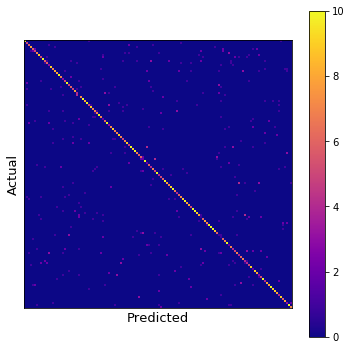


------------------------------
rf
Accuracy: 0.608955223880597
F1: 0.5683368869936034


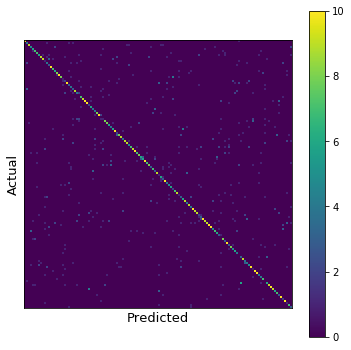


**************************************************
100 vocab size (scaled)
------------------------------
svc
Accuracy: 0.7007462686567163
F1: 0.6757960199004975


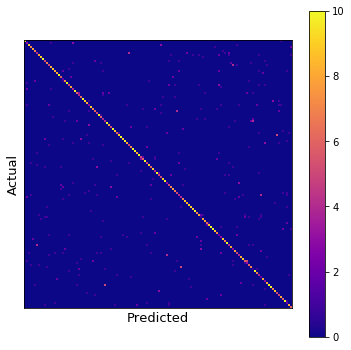


------------------------------
rf
Accuracy: 0.6037313432835821
F1: 0.5544337834636341


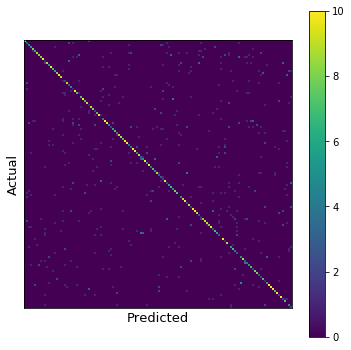


**************************************************
200 vocab size
------------------------------
svc
Accuracy: 0.7037313432835821
F1: 0.6775053304904051


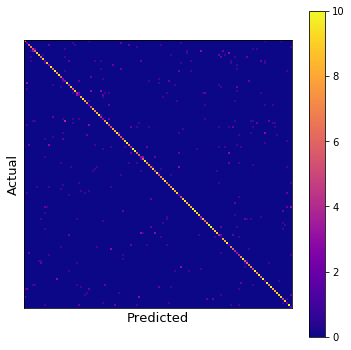


------------------------------
rf
Accuracy: 0.6029850746268657
F1: 0.5588438758588012


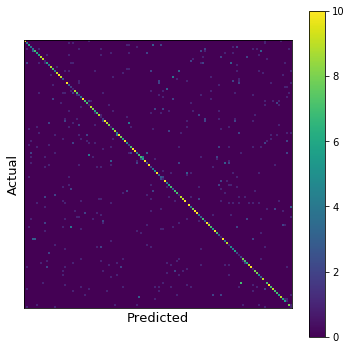


**************************************************
200 vocab size (scaled)
------------------------------
svc
Accuracy: 0.7492537313432835
F1: 0.7225799573560767


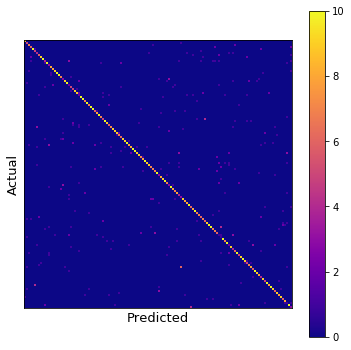


------------------------------
rf
Accuracy: 0.6156716417910448
F1: 0.5699502487562189


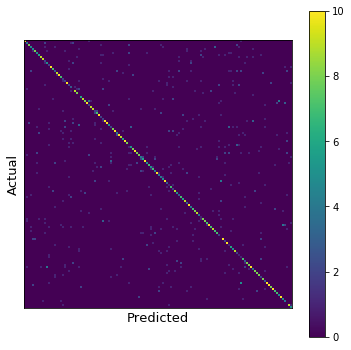


**************************************************
500 vocab size
------------------------------
svc
Accuracy: 0.7111940298507462
F1: 0.6873086946221274


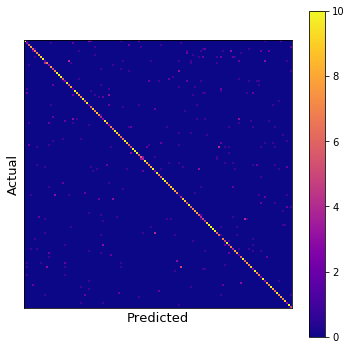


------------------------------
rf
Accuracy: 0.5925373134328358
F1: 0.5422861881070837


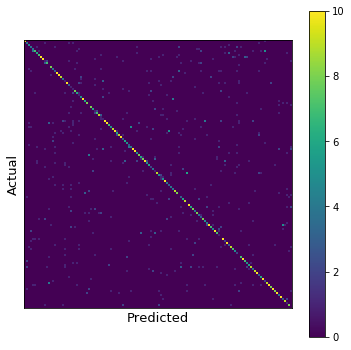


**************************************************
500 vocab size (scaled)
------------------------------
svc
Accuracy: 0.7537313432835822
F1: 0.7360341151385926


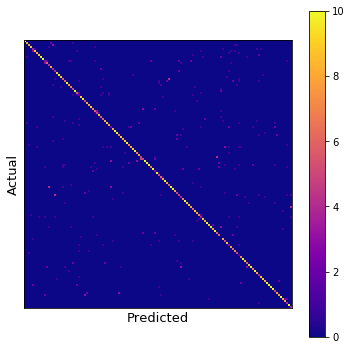


------------------------------
rf
Accuracy: 0.5835820895522389
F1: 0.5330208266029162


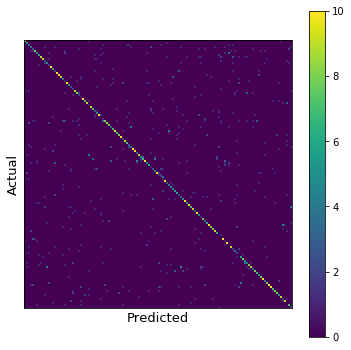


**************************************************
1000 vocab size
------------------------------
svc
Accuracy: 0.7156716417910449
F1: 0.6978713574982232


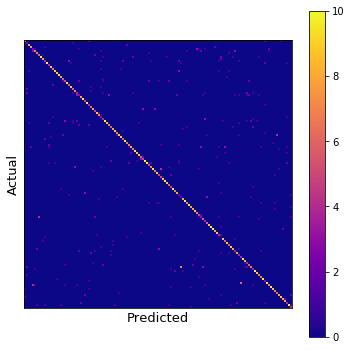


------------------------------
rf
Accuracy: 0.567910447761194
F1: 0.5261397557666214


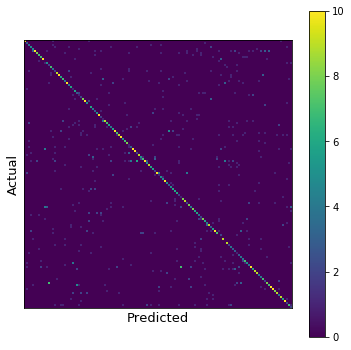


**************************************************
1000 vocab size (scaled)
------------------------------
svc
Accuracy: 0.7537313432835822
F1: 0.7394766427602247


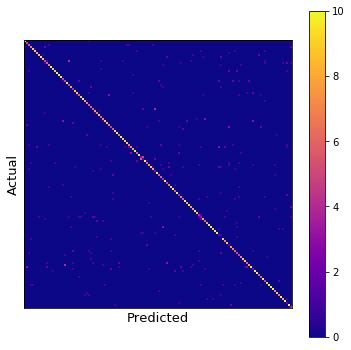


------------------------------
rf
Accuracy: 0.5708955223880597
F1: 0.5217164841791708


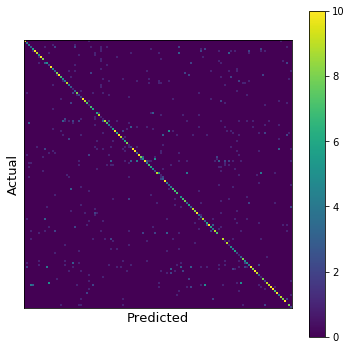

In [48]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    # Iterate over different classifiers
    for classifier, classifier_name, param_grid, cmap in zip(classifiers, 
                                                             classifiers_name, 
                                                             param_grids,
                                                             cmaps):
        print("-"*30)
        print(classifier_name)

        list_acc, list_cm, list_f1, list_cv_results = nested_cv_sklearn(classifier, param_grid, X, y, 5)
        # Add data to dict_results
        dict_results["accuracy"].append(list_acc)
        dict_results["f1"].append(list_f1)
        dict_results["cv_results"].append(list_cv_results)
        dict_results["cm"].append(list_cm)

        # Display accuracy, f1, confusion matrix
        print(f"Accuracy: {np.mean(list_acc)}")
        print(f"F1: {np.mean(list_f1)}")
        cm = sum(list_cm)

        plot_confusion_matrix(cm, cmap=cmap)

        print()
    
    list_dict_results.append(dict_results)

#### Neural Networks

In [56]:
le = LabelEncoder()
y_sift_le = le.fit_transform(y_sift)

In [57]:
## Loop configuration
feature_sets = [
    (X_100_scaled, y_sift_le),
    (X_200_scaled, y_sift_le),
    (X_500_scaled, y_sift_le),
    (X_1000_scaled, y_sift_le),
]
feature_sets_name = [
    "100 vocab size",
    "200 vocab size",
    "500 vocab size",
    "1000 vocab size",
]

In [58]:
# Neural network configuration (simple one for standard)
# see more complex version on utilities.ipynb that are evaluated
# on other files.
optimizer = keras.optimizers.Adam()
batch_size = 64
no_epochs = 200

**************************************************
100 vocab size
Accuracy: 0.8134328358208955
F1: 0.7728571428571428


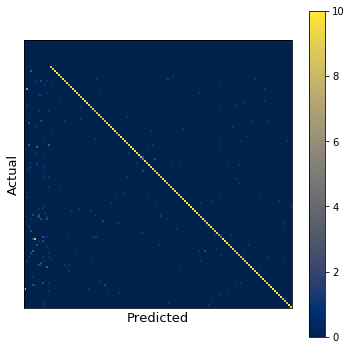


**************************************************
200 vocab size
Accuracy: 0.8283582089552238
F1: 0.7905780620705993


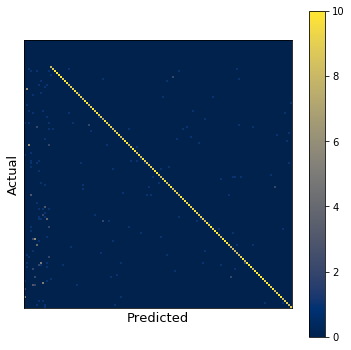


**************************************************
500 vocab size
Accuracy: 0.8373134328358208
F1: 0.7997180762852404


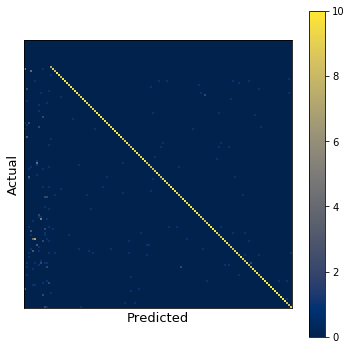


**************************************************
1000 vocab size
Accuracy: 0.8276119402985074
F1: 0.7886117033878228


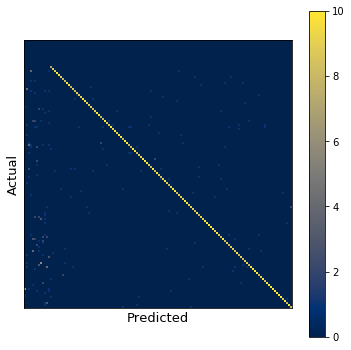

In [62]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Neural network training
    X = np.array(X)
    y = np.array(y)
    
    # Simple model definition
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(134, activation="softmax"),
        ]
    )
    
    for train, test in kfold.split(X, y):
        model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=optimizer,
                     metrics=["accuracy"])
        
        # Valid data
        valid_range = int(0.1 * len(train))
        valid = train[:valid_range]
        train = train[valid_range:]
        
        # Early stopping callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=50,
            mode="auto", restore_best_weights=False
        )
        
        # Fit data to model
        history = model.fit(X[train], y[train],
                  batch_size=batch_size,
                  epochs=no_epochs, verbose=0, 
                  validation_data=(X[valid], y[valid]),
                  callbacks=[early_stopping])
        
        # Generate generalisation metrics
        pred = model.predict(X[test])
        pred = np.argmax(pred, axis=1)
        cm = confusion_matrix(pred, y[test])
        acc = accuracy_score(pred, y[test])
        f1 = f1_score(pred, y[test], average="macro")
        
        # Add data to dict results
        dict_results["accuracy"].append(acc)
        dict_results["f1"].append(f1)
        dict_results["cm"].append(cm)
        
    # Display accuracy, f1, confusion matrix
    print(f"Accuracy: {np.mean(dict_results['accuracy'])}")
    print(f"F1: {np.mean(dict_results['f1'])}")
    plot_confusion_matrix(sum(dict_results['cm']), cmap="cividis")

    print()

    list_dict_results.append(dict_results)

## BRIEF

This section conduct feature extraction using BRIEF.

### Feature Extraction  

In [67]:
X_brief = []
y_brief = y_species
star = cv.xfeatures2d.StarDetector_create()
brief = cv.xfeatures2d.BriefDescriptorExtractor_create()

# Get feature descriptors from all images
for X in tqdm(X_species):
    X_a = X[0] # A position
    X_b = X[1]
    
    # Open the image in gray scale
    image_a = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_a),
                   cv2.IMREAD_GRAYSCALE)
    image_b = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_b),
                   cv2.IMREAD_GRAYSCALE)
    
    kp_a = star.detect(image_a, None)
    kp_b = star.detect(image_b, None)
    kp_a, descriptors_a = brief.compute(image_a, kp_a)
    kp_b, descriptors_b = brief.compute(image_b, kp_b)
    
    X_brief.append((descriptors_a, descriptors_b))

AttributeError: module 'cv2.xfeatures2d' has no attribute 'DescriptorExtractor_create'

In [35]:
# Concatenate rear and front view keypoints
X_brief_concatenate = [] # concatenated version of X_brief, considering front and rear views at once
for x in X_brief:
    X_brief_concatenate.append(np.concatenate((x[0], x[1])))

### Visualisation  

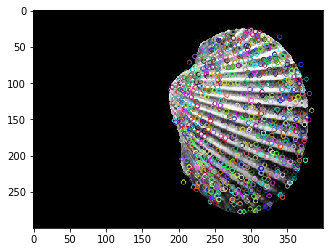

In [36]:
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][0]),
                   cv2.IMREAD_GRAYSCALE)
kp, descriptors = brief.compute(image1, None) # can add mask
img = cv2.drawKeypoints(image1, kp, None)
plt.imshow(img)
plt.show()

### Bag of Visual Words

In [37]:
## Build dictionary of visual words
# Concatenate all keypoints
X_brief_full = np.vstack(X_brief_concatenate)

# Build vocabulary of differing sizes
vocabulary_sizes = [100, 500, 1000] # we already have 200
for size in vocabulary_sizes:
    kmeans = KMeans(n_clusters=size)
    kmeans.fit(X_brief_full)
    filename = f"../results/vocab_{size}_brief.pickle"
    save_object(kmeans, filename)

In [44]:
## Load dictionary
kmeans_100 = load_object("../results/vocab_100_brief.pickle")
vocab_100 = kmeans_100.cluster_centers_

kmeans_200 = load_object("../results/vocab_200_brief.pickle")
vocab_200 = kmeans_200.cluster_centers_

kmeans_500 = load_object("../results/vocab_500_brief.pickle")
vocab_500 = kmeans_500.cluster_centers_

kmeans_1000 = load_object("../results/vocab_1000_brief.pickle")
vocab_1000 = kmeans_1000.cluster_centers_

In [45]:
# Build histograms
X_100_brief = build_histograms_brief(vocab_100, 100, X_species)
X_200_brief = build_histograms_brief(vocab_200, 200, X_species)
X_500_brief = build_histograms_brief(vocab_500, 500, X_species)
X_1000_brief = build_histograms_brief(vocab_1000, 1000, X_species)

# Whiten results
scaler = StandardScaler()
X_100_scaled_brief = scaler.fit_transform(X_100_brief)
X_200_scaled_brief = scaler.fit_transform(X_200_brief)
X_500_scaled_brief = scaler.fit_transform(X_500_brief)
X_1000_scaled_brief = scaler.fit_transform(X_1000_brief)

### Classification

#### Standard ML Models

The following consider SVC and random forest.

In [46]:
## Hyperparameter configurations and result storage
param_grid_svc = {
    # random search varying the parameter
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': ["scale", "auto"], 
    'kernel': ["rbf", "linear"]
}

param_grid_rf = { 
    'n_estimators': [10, 100, 200],
    'criterion' :['gini', 'entropy']
}

# Used to store results for different feature sets
list_dict_results = []

In [47]:
## Loop configuration
feature_sets = [
    (X_100_scaled_brief, y_brief),
    (X_200_scaled_brief, y_brief),
    (X_500_scaled_brief, y_brief),
    (X_1000_scaled_brief, y_brief),
]
feature_sets_name = [
    "100 vocab size",
    "200 vocab size",
    "500 vocab size",
    "1000 vocab size",
]

## Classifier and hyperparameter loops
param_grids = [param_grid_svc, param_grid_rf]
classifiers_name = ["svc", "rf"]
classifiers = [SVC(), RandomForestClassifier()]
cmaps = ["plasma", "viridis"]

**************************************************
100 vocab size
------------------------------
svc
Accuracy: 0.6798507462686566
F1: 0.6527327647476902


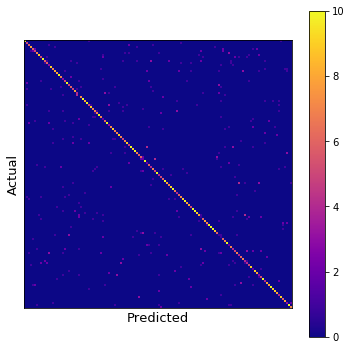


------------------------------
rf


In [ ]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    # Iterate over different classifiers
    for classifier, classifier_name, param_grid, cmap in zip(classifiers, 
                                                             classifiers_name, 
                                                             param_grids,
                                                             cmaps):
        print("-"*30)
        print(classifier_name)

        list_acc, list_cm, list_f1, list_cv_results = nested_cv_sklearn(classifier, param_grid, X, y, 5)
        # Add data to dict_results
        dict_results["accuracy"].append(list_acc)
        dict_results["f1"].append(list_f1)
        dict_results["cv_results"].append(list_cv_results)
        dict_results["cm"].append(list_cm)

        # Display accuracy, f1, confusion matrix
        print(f"Accuracy: {np.mean(list_acc)}")
        print(f"F1: {np.mean(list_f1)}")
        cm = sum(list_cm)

        plot_confusion_matrix(cm, cmap=cmap)

        print()
    
    list_dict_results.append(dict_results)

#### Neural Networks

In [ ]:
## Loop configuration
feature_sets = [
    (X_100_scaled_brief, y_brief),
    (X_200_scaled_brief, y_brief),
    (X_500_scaled_brief, y_brief),
    (X_1000_scaled_brief, y_brief),
]
feature_sets_name = [
    "100 vocab size",
    "200 vocab size",
    "500 vocab size",
    "1000 vocab size",
]

## Classifier and hyperparameter loops
param_grids = [param_grid_svc, param_grid_rf]
classifiers_name = ["svc", "rf"]
classifiers = [SVC(), RandomForestClassifier()]
cmaps = ["plasma", "viridis"]

In [ ]:
# Neural network configuration (simple one for standard)
# see more complex version on utilities.ipynb that are evaluated
# on other files.
optimizer = keras.optimizers.Adam()
batch_size = 64
no_epochs = 200

In [ ]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Neural network training
    X = np.array(X)
    y = np.array(y)
    
    # Simple model definition
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(134, activation="softmax"),
        ]
    )
    
    for train, test in kfold.split(X, y):
        model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=optimizer,
                     metrics=["accuracy"])
        
        # Valid data
        valid_range = int(0.1 * len(train))
        valid = train[:valid_range]
        train = train[valid_range:]
        
        # Early stopping callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=40,
            mode="auto", restore_best_weights=False
        )
        
        # Fit data to model
        history = model.fit(X[train], y[train],
                  batch_size=batch_size,
                  epochs=no_epochs, verbose=0, 
                  validation_data=(X[valid], y[valid]),
                  callbacks=[early_stopping])
        
        # Generate generalisation metrics
        pred = model.predict(X[test])
        pred = np.argmax(pred, axis=1)
        cm = confusion_matrix(pred, y[test])
        acc = accuracy_score(pred, y[test])
        f1 = f1_score(pred, y[test], average="macro")
        
        # Add data to dict results
        dict_results["accuracy"].append(acc)
        dict_results["f1"].append(f1)
        dict_results["cm"].append(cm)
        
    # Display accuracy, f1, confusion matrix
    print(f"Accuracy: {np.mean(dict_results['accuracy'])}")
    print(f"F1: {np.mean(dict_results['f1'])}")
    plot_confusion_matrix(sum(dict_results['cm']), cmap="cividis")

    print()

    list_dict_results.append(dict_results)

## ORB

This section conduct feature extraction using ORB.

### Feature Extraction  

In [11]:
X_orb = []
y_orb = y_species
orb = cv2.ORB_create()

# Get feature descriptors from all images
for X in tqdm(X_species):
    X_a = X[0] # A position
    X_b = X[1]
    
    # Open the image in gray scale
    image_a = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_a),
                   cv2.IMREAD_GRAYSCALE)
    image_b = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_b),
                   cv2.IMREAD_GRAYSCALE)
    
    kp_a, descriptors_a = orb.detectAndCompute(image_a, None)
    kp_b, descriptors_b = orb.detectAndCompute(image_b, None)
    
    X_orb.append((descriptors_a, descriptors_b))

In [5]:
# Concatenate rear and front view keypoints
X_orb_concatenate = [] # concatenated version of X_sift, considering front and rear views at once
for x in X_orb:
    X_orb_concatenate.append(np.concatenate((x[0], x[1])))

### Visualisation  

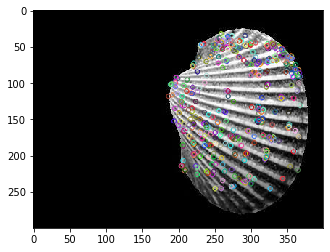

In [13]:
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][0]),
                   cv2.IMREAD_GRAYSCALE)
kp, descriptors = orb.detectAndCompute(image1, None) # can add mask
img = cv2.drawKeypoints(image1, kp, None)
plt.imshow(img)
plt.show()

In [6]:
X_orb_full = np.vstack(X_orb_concatenate)
X_orb_full.shape

(1057405, 32)

### Bag of Visual Words

In [ ]:
## Build dictionary of visual words
# Concatenate all keypoints
X_orb_full = np.vstack(X_orb_concatenate)

# Build vocabulary of differing sizes
vocabulary_sizes = [200, 800] # we already have 200
for size in vocabulary_sizes:
    kmeans = KMeans(n_clusters=size)
    kmeans.fit(X_orb_full)
    filename = f"../results/vocab_{size}_orb.pickle"
    save_object(kmeans, filename)

In [5]:
## Load dictionary
kmeans_100 = load_object("../results/vocab_100_orb.pickle")
vocab_100 = kmeans_100.cluster_centers_

kmeans_200 = load_object("../results/vocab_200_orb.pickle")
vocab_200 = kmeans_200.cluster_centers_

kmeans_500 = load_object("../results/vocab_500_orb.pickle")
vocab_500 = kmeans_500.cluster_centers_

kmeans_1000 = load_object("../results/vocab_1000_orb.pickle")
vocab_1000 = kmeans_1000.cluster_centers_

In [7]:
# Build histograms
orb = cv2.ORB_create()
X_100 = build_histograms(vocab_100, 100, X_species, orb)
X_200 = build_histograms(vocab_200, 200, X_species, orb)
X_500 = build_histograms(vocab_500, 500, X_species, orb)
X_1000 = build_histograms(vocab_1000, 1000, X_species, orb)

# Whiten results
scaler = StandardScaler()
X_100_scaled_orb = scaler.fit_transform(X_100)
X_200_scaled_orb = scaler.fit_transform(X_200)
X_500_scaled_orb = scaler.fit_transform(X_500)
X_1000_scaled_orb = scaler.fit_transform(X_1000)

### Classification

#### Standard ML Models

The following consider SVC and random forest.

In [8]:
## Hyperparameter configurations and result storage
param_grid_svc = {
    # random search varying the parameter
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': ["scale", "auto"], 
    'kernel': ["rbf", "linear"]
}

param_grid_rf = { 
    'n_estimators': [10, 100, 200],
    'criterion' :['gini', 'entropy']
}

# Used to store results for different feature sets
list_dict_results = []

In [12]:
## Loop configuration
feature_sets = [
    (X_100_scaled_orb, y_orb),
    (X_200_scaled_orb, y_orb),
    (X_500_scaled_orb, y_orb),
    (X_1000_scaled_orb, y_orb),
]
feature_sets_name = [
    "100 vocab size",
    "200 vocab size",
    "500 vocab size",
    "1000 vocab size",
]

## Classifier and hyperparameter loops
param_grids = [param_grid_svc, param_grid_rf]
classifiers_name = ["svc", "rf"]
classifiers = [SVC(), RandomForestClassifier()]
cmaps = ["plasma", "viridis"]

**************************************************
100 vocab size
------------------------------
svc
Accuracy: 0.7171641791044776
F1: 0.6948673300165836


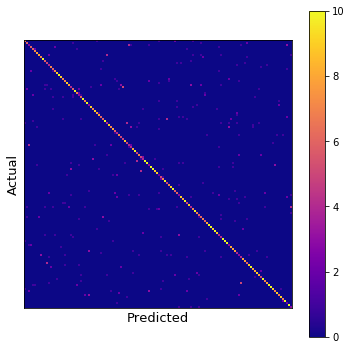


------------------------------
rf
Accuracy: 0.5761194029850747
F1: 0.5293319118692252


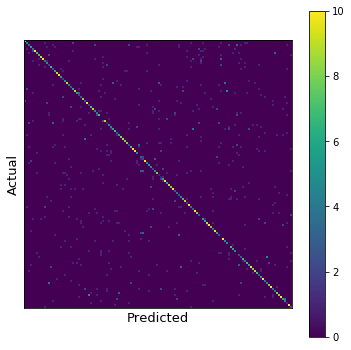


**************************************************
200 vocab size
------------------------------
svc


In [ ]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    # Iterate over different classifiers
    for classifier, classifier_name, param_grid, cmap in zip(classifiers, 
                                                             classifiers_name, 
                                                             param_grids,
                                                             cmaps):
        print("-"*30)
        print(classifier_name)

        list_acc, list_cm, list_f1, list_cv_results = nested_cv_sklearn(classifier, param_grid, X, y, 5)
        # Add data to dict_results
        dict_results["accuracy"].append(list_acc)
        dict_results["f1"].append(list_f1)
        dict_results["cv_results"].append(list_cv_results)
        dict_results["cm"].append(list_cm)

        # Display accuracy, f1, confusion matrix
        print(f"Accuracy: {np.mean(list_acc)}")
        print(f"F1: {np.mean(list_f1)}")
        cm = sum(list_cm)

        plot_confusion_matrix(cm, cmap=cmap)

        print()
    
    list_dict_results.append(dict_results)

#### Neural Networks

In [ ]:
## Loop configuration
feature_sets = [
    (X_100_scaled_orb, y_orb),
    (X_200_scaled_orb, y_orb),
    (X_500_scaled_orb, y_orb),
    (X_1000_scaled_orb, y_orb),
]
feature_sets_name = [
    "100 vocab size (scaled)",
    "200 vocab size (scaled)",
    "500 vocab size (scaled)",
    "1000 vocab size (scaled)",
]

In [ ]:
# Neural network configuration (simple one for standard)
# see more complex version on utilities.ipynb that are evaluated
# on other files.
optimizer = keras.optimizers.Adam()
batch_size = 64
no_epochs = 200

In [ ]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Neural network training
    X = np.array(X)
    y = np.array(y)
    
    # Simple model definition
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(134, activation="softmax"),
        ]
    )
    
    for train, test in kfold.split(X, y):
        model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=optimizer,
                     metrics=["accuracy"])
        
        # Valid data
        valid_range = int(0.1 * len(train))
        valid = train[:valid_range]
        train = train[valid_range:]
        
        # Early stopping callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=40,
            mode="auto", restore_best_weights=False
        )
        
        # Fit data to model
        history = model.fit(X[train], y[train],
                  batch_size=batch_size,
                  epochs=no_epochs, verbose=0, 
                  validation_data=(X[valid], y[valid]),
                  callbacks=[early_stopping])
        
        # Generate generalisation metrics
        pred = model.predict(X[test])
        pred = np.argmax(pred, axis=1)
        cm = confusion_matrix(pred, y[test])
        acc = accuracy_score(pred, y[test])
        f1 = f1_score(pred, y[test], average="macro")
        
        # Add data to dict results
        dict_results["accuracy"].append(acc)
        dict_results["f1"].append(f1)
        dict_results["cm"].append(cm)
        
    # Display accuracy, f1, confusion matrix
    print(f"Accuracy: {np.mean(dict_results['accuracy'])}")
    print(f"F1: {np.mean(dict_results['f1'])}")
    plot_confusion_matrix(sum(dict_results['cm']), cmap="cividis")

    print()

    list_dict_results.append(dict_results)

## BRISK

This section conduct feature extraction using BRISK.

### Feature Extraction  

In [6]:
X_surf = []
y_surf = y_species
surf = cv2.xfeatures2d.BRISK_create(30)

# Get feature descriptors from all images
for X in tqdm(X_orb):
    X_a = X[0] # A position
    X_b = X[1]
    
    # Open the image in gray scale
    image_a = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_a),
                   cv2.IMREAD_GRAYSCALE)
    image_b = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_b),
                   cv2.IMREAD_GRAYSCALE)
    
    kp_a, descriptors_a = surf.detectAndCompute(image_a, None)
    kp_b, descriptors_b = surf.detectAndCompute(image_b, None)
    
    X_surf.append((descriptors_a, descriptors_b))

error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv_contrib/modules/xfeatures2d/src/surf.cpp:1027: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'


In [35]:
# Concatenate rear and front view keypoints
X_surf_concatenate = [] # concatenated version of X_sift, considering front and rear views at once
for x in X_surf:
    X_surf_concatenate.append(np.concatenate((x[0], x[1])))

### Visualisation  

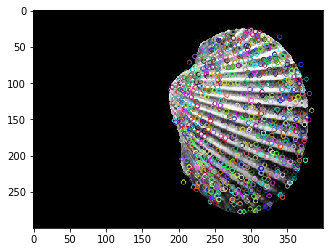

In [36]:
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][0]),
                   cv2.IMREAD_GRAYSCALE)
kp, descriptors = surf.detectAndCompute(image1, None) # can add mask
img = cv2.drawKeypoints(image1, kp, None)
plt.imshow(img)
plt.show()

### Bag of Visual Words

In [37]:
## Build dictionary of visual words
# Concatenate all keypoints
X_surf_full = np.vstack(X_surf_concatenate)

# Build vocabulary of differing sizes
vocabulary_sizes = [100, 500, 1000] # we already have 200
for size in vocabulary_sizes:
    kmeans = KMeans(n_clusters=size)
    kmeans.fit(X_surf_full)
    filename = f"../results/vocab_{size}_brisk.pickle"
    save_object(kmeans, filename)

In [44]:
## Load dictionary
kmeans_100 = load_object("../results/vocab_100_brisk.pickle")
vocab_100 = kmeans_100.cluster_centers_

kmeans_200 = load_object("../results/vocab_200_brisk.pickle")
vocab_200 = kmeans_200.cluster_centers_

kmeans_500 = load_object("../results/vocab_500_brisk.pickle")
vocab_500 = kmeans_500.cluster_centers_

kmeans_1000 = load_object("../results/vocab_1000_brisk.pickle")
vocab_1000 = kmeans_1000.cluster_centers_

In [45]:
# Build histograms
X_100 = build_histograms(vocab_100, 100, X_species, orb)
X_200 = build_histograms(vocab_200, 200, X_species, orb)
X_500 = build_histograms(vocab_500, 500, X_species, orb)
X_1000 = build_histograms(vocab_1000, 1000, X_species, orb)

# Whiten results
scaler = StandardScaler()
X_100_scaled_surf = scaler.fit_transform(X_100)
X_200_scaled_surf = scaler.fit_transform(X_200)
X_500_scaled_surf = scaler.fit_transform(X_500)
X_1000_scaled_surf = scaler.fit_transform(X_1000)

### Classification

#### Standard ML Models

The following consider SVC and random forest.

In [46]:
## Hyperparameter configurations and result storage
param_grid_svc = {
    # random search varying the parameter
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': ["scale", "auto"], 
    'kernel': ["rbf", "linear"]
}

param_grid_rf = { 
    'n_estimators': [10, 100, 200],
    'criterion' :['gini', 'entropy']
}

# Used to store results for different feature sets
list_dict_results = []

In [47]:
## Loop configuration
feature_sets = [
    (X_100_scaled_surf, y_sift),
    (X_200_scaled_surf, y_sift),
    (X_500_scaled_surf, y_sift),
    (X_1000_scaled_surf, y_sift),
]
feature_sets_name = [
    "100 vocab size",
    "200 vocab size",
    "500 vocab size",
    "1000 vocab size",
]

## Classifier and hyperparameter loops
param_grids = [param_grid_svc, param_grid_rf]
classifiers_name = ["svc", "rf"]
classifiers = [SVC(), RandomForestClassifier()]
cmaps = ["plasma", "viridis"]

**************************************************
100 vocab size
------------------------------
svc
Accuracy: 0.6798507462686566
F1: 0.6527327647476902


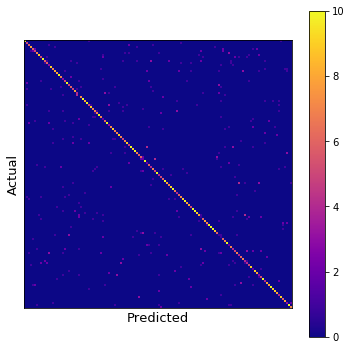


------------------------------
rf


In [ ]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    # Iterate over different classifiers
    for classifier, classifier_name, param_grid, cmap in zip(classifiers, 
                                                             classifiers_name, 
                                                             param_grids,
                                                             cmaps):
        print("-"*30)
        print(classifier_name)

        list_acc, list_cm, list_f1, list_cv_results = nested_cv_sklearn(classifier, param_grid, X, y, 5)
        # Add data to dict_results
        dict_results["accuracy"].append(list_acc)
        dict_results["f1"].append(list_f1)
        dict_results["cv_results"].append(list_cv_results)
        dict_results["cm"].append(list_cm)

        # Display accuracy, f1, confusion matrix
        print(f"Accuracy: {np.mean(list_acc)}")
        print(f"F1: {np.mean(list_f1)}")
        cm = sum(list_cm)

        plot_confusion_matrix(cm, cmap=cmap)

        print()
    
    list_dict_results.append(dict_results)

#### Neural Networks

In [ ]:
## Loop configuration
feature_sets = [
    (X_100_scaled_surf, y_sift),
    (X_200_scaled_surf, y_sift),
    (X_500_scaled_surf, y_sift),
    (X_1000_scaled_surf, y_sift),
]
feature_sets_name = [
    "100 vocab size (scaled)",
    "200 vocab size (scaled)",
    "500 vocab size (scaled)",
    "1000 vocab size (scaled)",
]

In [ ]:
# Neural network configuration (simple one for standard)
# see more complex version on utilities.ipynb that are evaluated
# on other files.
optimizer = keras.optimizers.Adam()
batch_size = 64
no_epochs = 200

In [ ]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Neural network training
    X = np.array(X)
    y = np.array(y)
    
    # Simple model definition
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(134, activation="softmax"),
        ]
    )
    
    for train, test in kfold.split(X, y):
        model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=optimizer,
                     metrics=["accuracy"])
        
        # Valid data
        valid_range = int(0.1 * len(train))
        valid = train[:valid_range]
        train = train[valid_range:]
        
        # Early stopping callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=40,
            mode="auto", restore_best_weights=False
        )
        
        # Fit data to model
        history = model.fit(X[train], y[train],
                  batch_size=batch_size,
                  epochs=no_epochs, verbose=0, 
                  validation_data=(X[valid], y[valid]),
                  callbacks=[early_stopping])
        
        # Generate generalisation metrics
        pred = model.predict(X[test])
        pred = np.argmax(pred, axis=1)
        cm = confusion_matrix(pred, y[test])
        acc = accuracy_score(pred, y[test])
        f1 = f1_score(pred, y[test], average="macro")
        
        # Add data to dict results
        dict_results["accuracy"].append(acc)
        dict_results["f1"].append(f1)
        dict_results["cm"].append(cm)
        
    # Display accuracy, f1, confusion matrix
    print(f"Accuracy: {np.mean(dict_results['accuracy'])}")
    print(f"F1: {np.mean(dict_results['f1'])}")
    plot_confusion_matrix(sum(dict_results['cm']), cmap="cividis")

    print()

    list_dict_results.append(dict_results)